# **RFM Segmentation**

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import squarify
from datetime import datetime
# !pip install openpyxl

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
columns = ['CustomerID', 'InvoiceDate', 'Quantity', 'TotalAmountSpent']
df = pd.read_csv("CDNOW_master.txt", header = None, delim_whitespace=True, names = columns)

# **Checking the data**


In [3]:
df.shape

(69659, 4)

In [4]:
df.dtypes

CustomerID            int64
InvoiceDate           int64
Quantity              int64
TotalAmountSpent    float64
dtype: object

In [5]:
df.describe()

CustomerID   InvoiceDate      Quantity  TotalAmountSpent
count  69659.000000  6.965900e+04  69659.000000      69659.000000
mean   11470.854592  1.997228e+07      2.410040         35.893648
std     6819.904848  3.837735e+03      2.333924         36.281942
min        1.000000  1.997010e+07      1.000000          0.000000
25%     5506.000000  1.997022e+07      1.000000         14.490000
50%    11410.000000  1.997042e+07      2.000000         25.980000
75%    17273.000000  1.997111e+07      3.000000         43.700000
max    23570.000000  1.998063e+07     99.000000       1286.010000

Cột Quantity và TotalAmountSpent có dữ liệu negative có thể gây ảnh hưởng đến kết quả, cụ thể:
* Cột TotalAmountSpent có Min = 0 (có thể do khách hàng mua xong rồi đổi trả hàng)
* Khi nhìn vào giá trị 75% và Max ta thấy cả 2 cột đều có outlier

In [6]:
df.head()

CustomerID  InvoiceDate  Quantity  TotalAmountSpent
0           1     19970101         1             11.77
1           2     19970112         1             12.00
2           2     19970112         5             77.00
3           3     19970102         2             20.76
4           3     19970330         2             20.76

### **Finding unique values**

In [7]:
print('Có tổng cộng '+ str(df.InvoiceDate.nunique()) +' ngày bán hàng được thống kê trong bộ dữ liệu.')

Có tổng cộng 546 ngày bán hàng được thống kê trong bộ dữ liệu.


In [8]:
# We are renaming the CustomerID for our conveniency

print('Có '+ str(df.CustomerID.nunique()) +' ID khách hàng trong bộ dữ liệu.')

Có 23570 ID khách hàng trong bộ dữ liệu.


## **Data Preprocessing**


### **Null Value Check**

In [9]:
# Check Null Values.
df.isnull().sum().sort_values(ascending=False)

CustomerID          0
InvoiceDate         0
Quantity            0
TotalAmountSpent    0
dtype: int64

### **Corelation Check**

<Axes: >

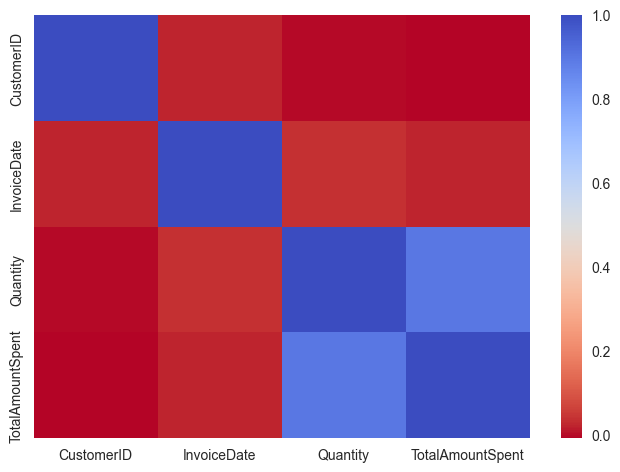

In [10]:
corrDf = df.corr()
sns.heatmap(corrDf, 
        xticklabels=corrDf.columns,
        yticklabels=corrDf.columns, cmap='coolwarm_r')

Chỉ có cột Quantity và TotalAmountSpent có liên quan với nhau

### **Dropping negative values**

Loại bỏ các dữ liệu negative ở cột Quantity và TotalAmountSpent

In [11]:
df = df[(df['Quantity']>0) & (df['TotalAmountSpent']>0)] 
df.describe()

CustomerID   InvoiceDate      Quantity  TotalAmountSpent
count  69579.000000  6.957900e+04  69579.000000      69579.000000
mean   11472.165812  1.997228e+07      2.411662         35.934918
std     6819.453839  3.838495e+03      2.334775         36.282363
min        1.000000  1.997010e+07      1.000000          1.630000
25%     5509.000000  1.997022e+07      1.000000         14.490000
50%    11414.000000  1.997042e+07      2.000000         25.980000
75%    17273.000000  1.997111e+07      3.000000         43.700000
max    23570.000000  1.998063e+07     99.000000       1286.010000

In [12]:
df.shape

(69579, 4)

### **Removing duplicates**

In [13]:
df=df.drop_duplicates()
df.shape

(69324, 4)

## **RFM Analysis**

In [14]:
df.InvoiceDate.max()

19980630

In [15]:
string_to_date = lambda x : datetime.strptime(x, "%Y%m%d").date()

# Convert InvoiceDate from object to datetime format
df['InvoiceDate'] = df['InvoiceDate'].astype('str')
df['InvoiceDate'] = df['InvoiceDate'].apply(string_to_date)
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

# Drop NA values
df = df.dropna()

In [16]:
# RFM
# Convert string to date, get max date of dataframe
max_date = df['InvoiceDate'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': Recency,
                                        'Quantity': Frequency,  
                                        'TotalAmountSpent': Monetary })

### Changing the column names

In [17]:
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm["monetary"] > 0]
rfm.head()

recency  frequency  monetary
CustomerID                              
1               545          1     11.77
2               534          2     89.00
3                33          4    156.46
4               200          2    100.50
5               178          4    385.61

In [18]:
### Lưu dữ liệu đã xử lý
rfm.to_csv('df_RFM.csv', index = False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20876\2235983119.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['recency'])# Plot distribution of R
C:\Users\DELL\AppData\Local\Temp\ipykernel_20876\2235983119.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['frequency'])# Plot distribu

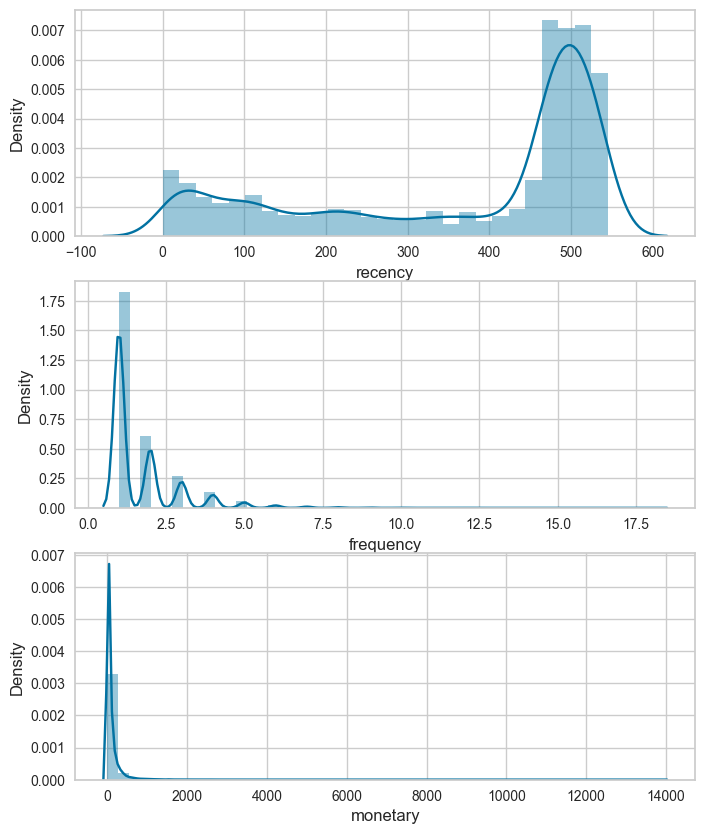

In [19]:
### Trực quan hóa dữ liệu
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sns.distplot(rfm['recency'])# Plot distribution of R
plt.subplot(3, 1, 2)
sns.distplot(rfm['frequency'])# Plot distribution of F
plt.subplot(3, 1, 3)
sns.distplot(rfm['monetary']) # Plot distribution of M
plt.show()

### **Calculate the score**

Chia các cột recency, frequency and monetary với thang điểm từ 1 đến 5 cho mỗi khách hàng

In [20]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm['score']=rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)

In [21]:
rfm.head()

recency  frequency  monetary recency_score frequency_score  \
CustomerID                                                               
1               545          1     11.77             1               1   
2               534          2     89.00             1               4   
3                33          4    156.46             5               5   
4               200          2    100.50             4               4   
5               178          4    385.61             4               5   

           monetary_score  score  
CustomerID                        
1                       1      3  
2                       4      9  
3                       5     15  
4                       4     12  
5                       5     14

In [22]:
rfm.score.unique()

array([ 3,  9, 15, 12, 14,  4, 10,  5,  6, 13, 11,  8,  7])

### Best customers

Khách hàng tốt nhất là khách hàng có tổng số điểm của 3 cột bằng 15

In [23]:
rfm[rfm['score']== 15].sort_values('monetary', ascending=False).head()

recency  frequency  monetary recency_score frequency_score  \
CustomerID                                                               
7592              1         17  13925.98             5               5   
14048             0         15   8976.33             5               5   
7983              5         14   6960.08             5               5   
7931             17         18   6497.18             5               5   
6569              7         14   4968.00             5               5   

           monetary_score  score  
CustomerID                        
7592                    5     15  
14048                   5     15  
7983                    5     15  
7931                    5     15  
6569                    5     15

Họ là tài sản của công ty

### **Number of best customers** 

In [24]:
rfm[rfm['score']==15].count()

recency            2356
frequency          2356
monetary           2356
recency_score      2356
frequency_score    2356
monetary_score     2356
score              2356
dtype: int64

Có 2356 khách hàng tốt nhất là những người mua hàng thường xuyên và cũng mang lại doanh thu cao.

## **Seggregate the levels**

**Phân chia** cấp độ của khách hàng **dựa trên điểm số** thành **4 cấp độ**.

**Active**: Tạo doanh thu cao và mua hàng thường xuyên.

**Good**: Khách hàng mua hàng khá thường xuyên và tạo ra doanh thu vừa phải.

**Average** : Những khách hàng ít hoạt động hơn, không mua thường xuyên và tạo ra doanh thu thấp.

**Inactive**: Khách hàng tạo ra doanh thu rất thấp và không mua hàng thường xuyên.

### Manual Segmentation

In [25]:
def rfm_level(score):
    if  ((score >1) and (score < 4)):
        return 'Inactive'
    elif ((score >3) and (score < 8)):
        return 'Average'
    elif ((score > 7) and (score <11)):
        return 'Good'
    else:
        return 'Active'

In [26]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

recency  frequency  monetary recency_score frequency_score  \
CustomerID                                                               
1               545          1     11.77             1               1   
2               534          2     89.00             1               4   
3                33          4    156.46             5               5   
4               200          2    100.50             4               4   
5               178          4    385.61             4               5   

           monetary_score  score     level  
CustomerID                                  
1                       1      3  Inactive  
2                       4      9      Good  
3                       5     15    Active  
4                       4     12    Active  
5                       5     14    Active

In [27]:
rfm[::2000]

recency  frequency  monetary recency_score frequency_score  \
CustomerID                                                               
1               545          1     11.77             1               1   
2013            335          4    299.94             4               5   
4021            529          1     25.74             1               1   
6027            486          2     45.69             2               4   
8032            166          5    383.34             4               5   
10036            13          3    242.20             5               5   
12042           502          1     75.83             2               2   
14046            79          2    261.91             5               4   
16050           489          1     15.36             2               3   
18054           143          3    296.16             4               5   
20060           369          2     98.03             4               4   
22064           411          1     41.90             4               3   

           monetary_score  score     level  
CustomerID                                  
1                       1      3  Inactive  
2013                    5     14    Active  
4021                    2      4   Average  
6027                    3      9      Good  
8032                    5     14    Active  
10036                   5     15    Active  
12042                   4      8      Good  
14046                   5     14    Active  
16050                   1      6   Average  
18054                   5     14    Active  
20060                   4     12    Active  
22064                   3     10      Good

### Visualising number of customers for each level

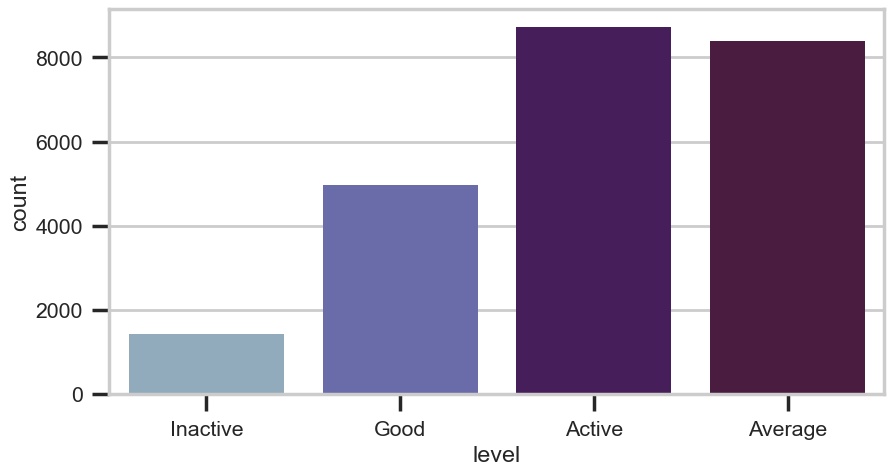

In [28]:
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(x = rfm['level'], data = rfm)
plt.show()

Từ biểu đồ thanh trên, chúng ta có thể suy ra rằng:
* Chỉ có một số ít khách hàng Không hoạt động khi so sánh với các cấp độ khác.
* Thật tốt khi nhận thấy rằng có nhiều khách hàng đang hoạt động hơn.

### Analysing each level

Để hiểu rõ hơn về từng phân khúc khách hàng, chúng ta sẽ đi sâu vào từng phân khúc.

In [29]:
rfm.groupby('level').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary' : ['mean','min','max','count']
})

recency           frequency            monetary                   \
                mean  min  max      mean min max        mean    min       max   
level                                                                           
Active    183.088239    0  536  2.841308   1  18  229.410679  15.96  13925.98   
Average   501.703580   48  545  1.000239   1   2   27.656612   3.99    432.76   
Good      414.605586    0  544  1.139441   1   3   49.580753   4.79    653.01   
Inactive  529.766434  513  545  1.000000   1   1   12.687315   3.99     15.36   

                
         count  
level           
Active    8715  
Average   8380  
Good      4977  
Inactive  1430

### Active Customers

Có 8715 khách hàng đã mua với số tiền trung bình là 229.41$, mua sắm 3 lần trong khoảng 184 ngày.

Họ là những khách hàng ưu tiên.


Ưu đãi bất ngờ có thể được đưa ra vào ngày sinh nhật và ngày kỷ niệm.

### Good Customers

Có 4977 khách hàng đã mua với số tiền trung bình là 49.58$, mua sắm 1 lần trong khoảng 415 ngày

Họ là những khách hàng trung thành

### Average customers

Có 8380 khách hàng đã mua với số tiền trung bình là 27.66$, mua sắm 1 lần trong khoảng 502 ngày

Có thể giới thiệu với họ các tầng định giá sản phẩm phù hợp

### Inactive customers

Có 1430 khách hàng đã mua với số tiền trung bình là 12.69$, mua sắm 1 lần trong khoảng 530 ngày

Có thể gửi cho khách hàng thông tin về các ưu đãi thông qua Email và SMS được cá nhân hóa. 

Có thể sử dụng nhiều chiến lược marketing hơn để thúc đẩy tần suất đặt hàng.

### Visualizing against each of the factors 

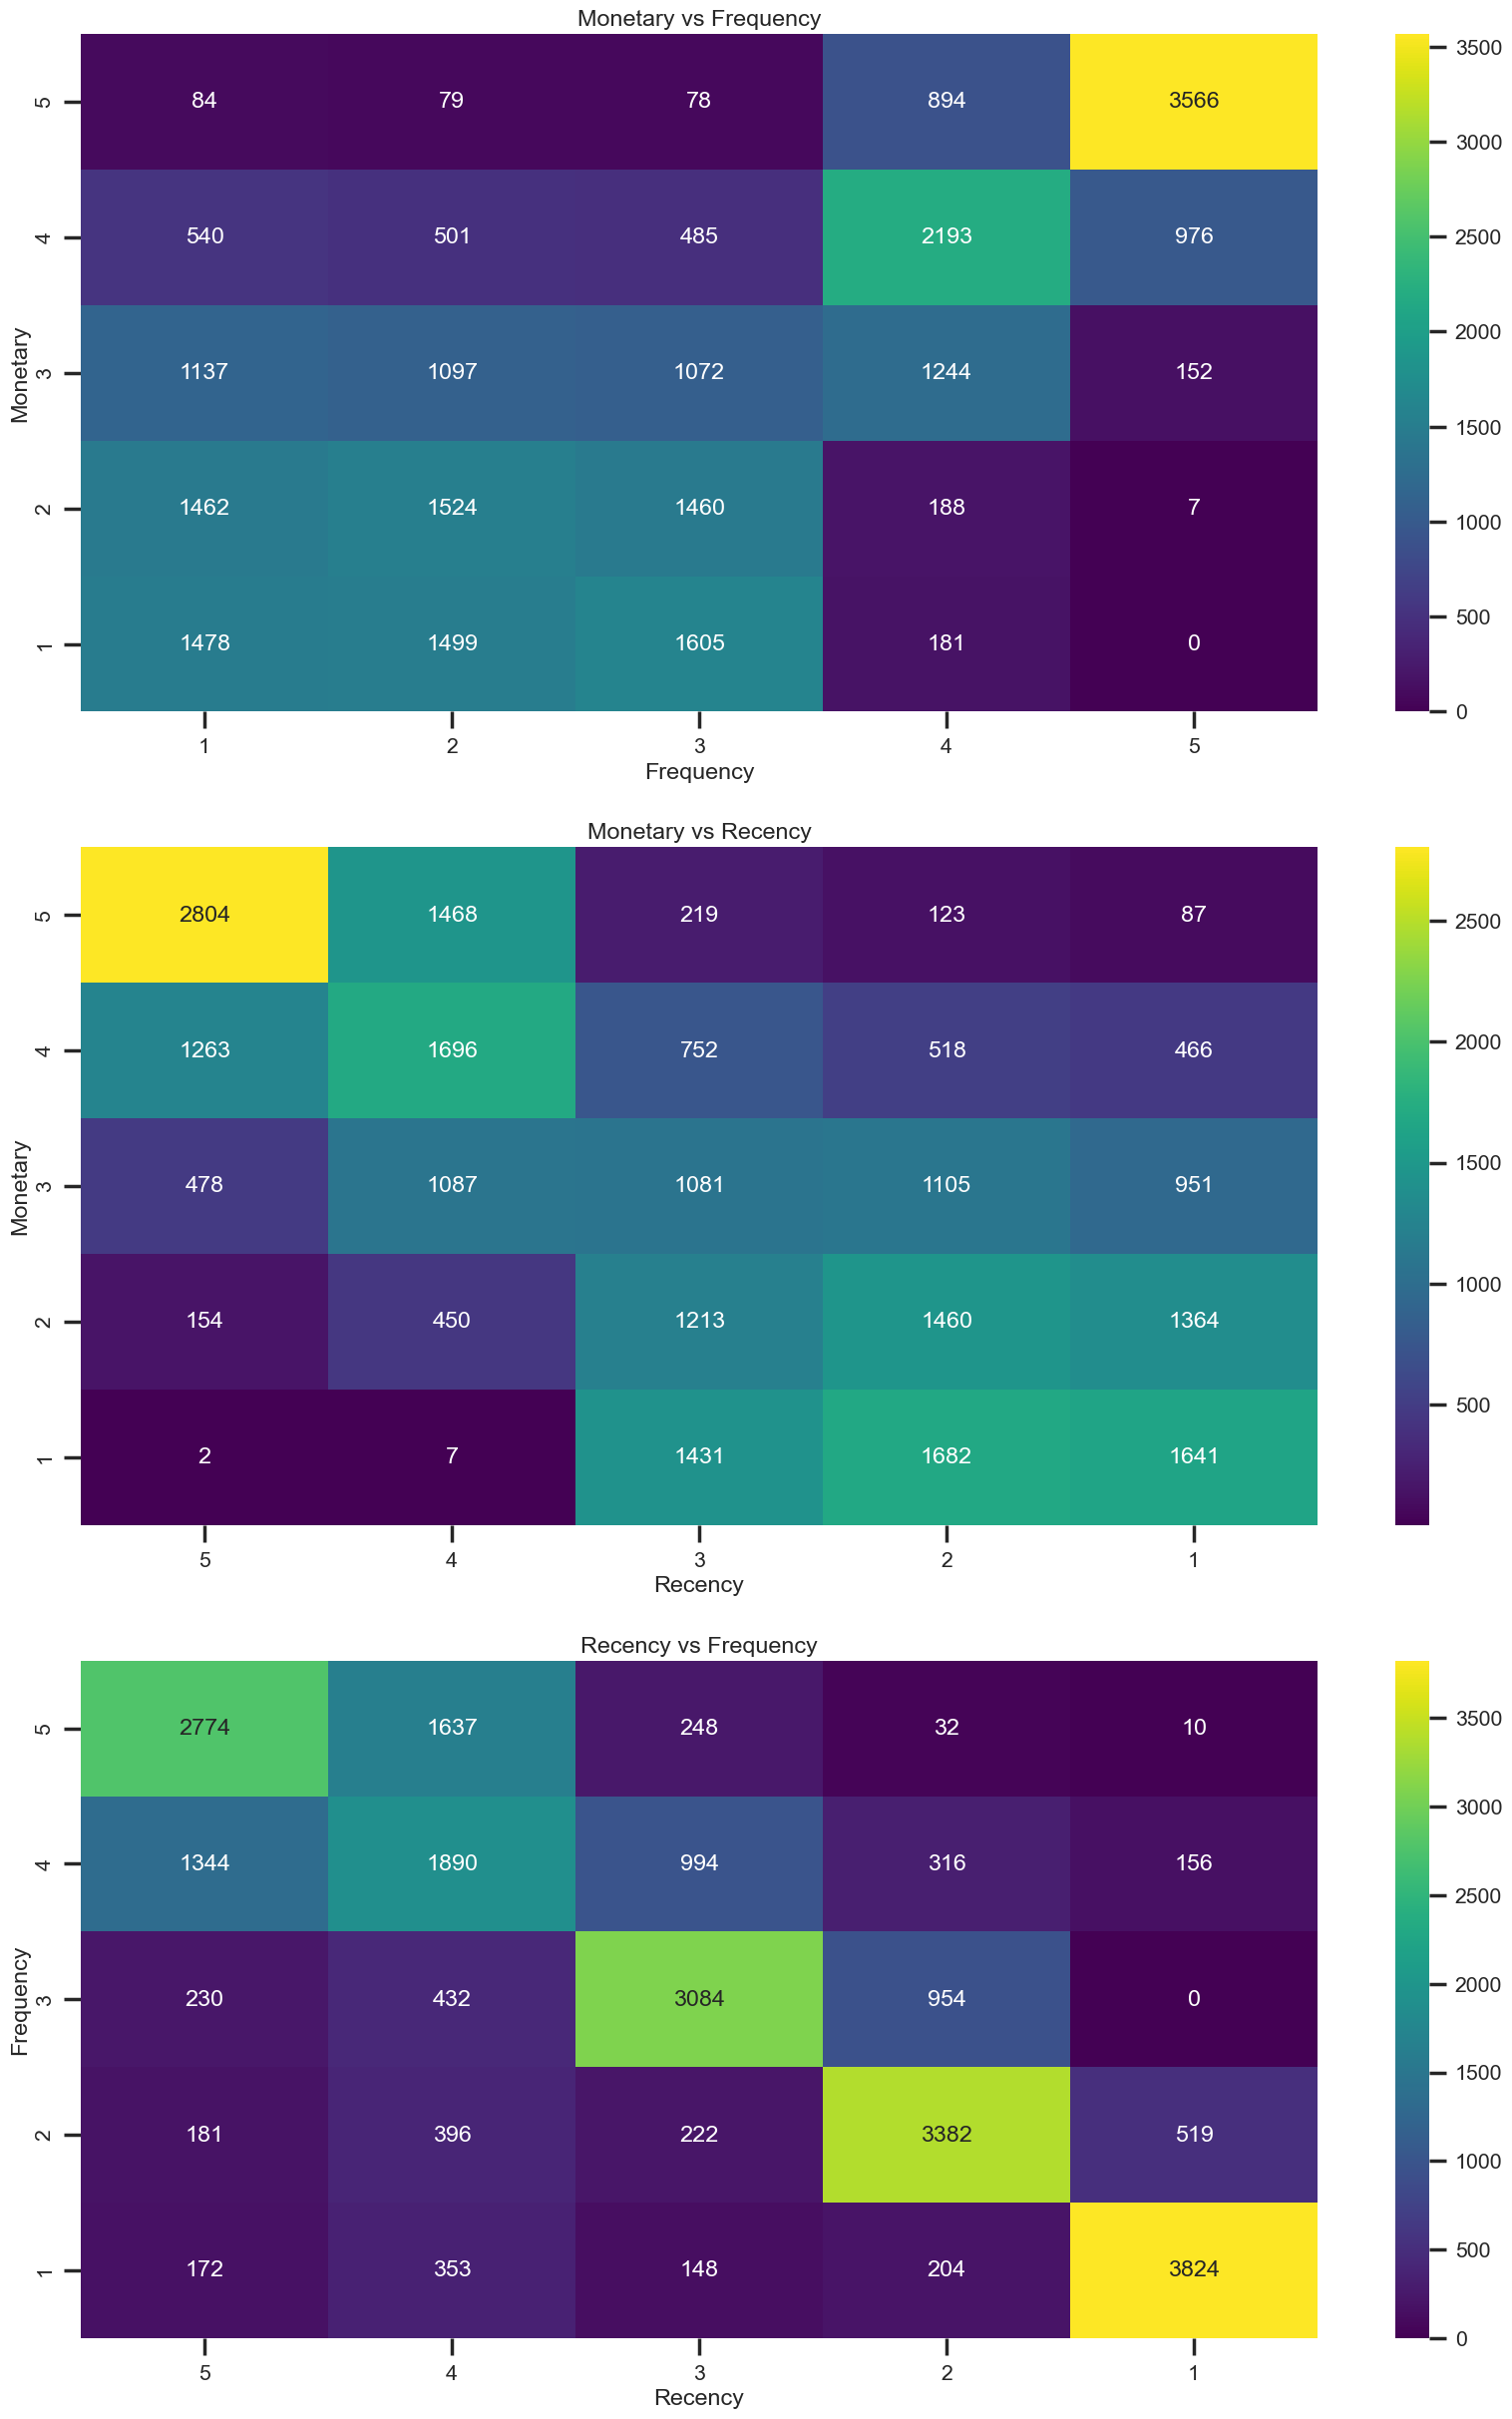

In [30]:
cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

#### Number of segments

In [31]:
import plotly.express as px

colors_dict = {'Active':'red','Good':'royalblue', 'Average':'cyan',
               'Inactive':'purple'}

fig = px.scatter_3d(rfm, x='recency', y='frequency', z='monetary',
                    color = 'level', opacity=0.5,
                    color_discrete_map = colors_dict)
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='markers'))
fig.show()

In [32]:
rfm['level'].value_counts()

Active      8715
Average     8380
Good        4977
Inactive    1430
Name: level, dtype: int64

#### Calculate mean values for each segment

In [33]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = rfm.groupby('level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [34]:
rfm_agg

level  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0    Active        183.0            3.0         229.0   8715    37.08
1   Average        502.0            1.0          28.0   8380    35.66
2      Good        415.0            1.0          50.0   4977    21.18
3  Inactive        530.0            1.0          13.0   1430     6.08

#### TreeMap

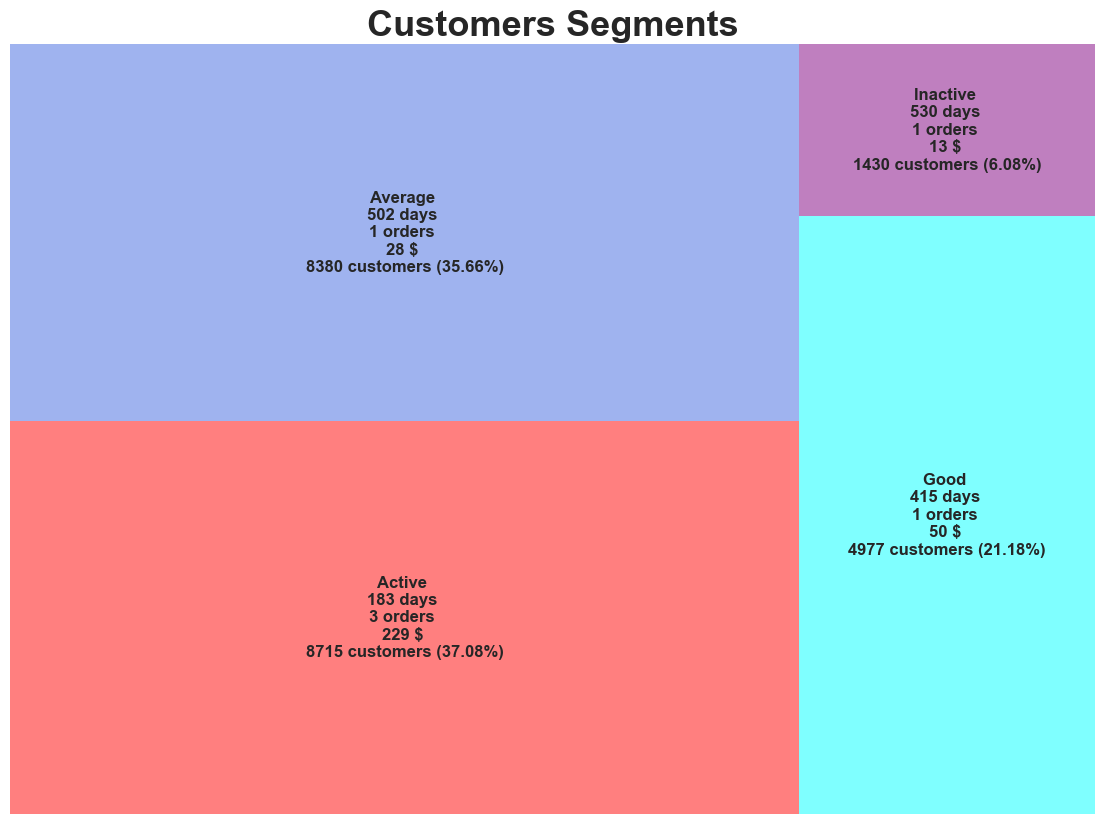

In [35]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'Active':'red','Good':'royalblue', 'Average':'cyan',
               'Inactive':'purple'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

#### Scatter Plot (RFM)

In [36]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="level",
           hover_name="level", size_max=100)
fig.show()

#### 3d Scatter Plot (RFM)

In [37]:
import plotly.express as px

fig = px.scatter_3d(rfm_agg, x='RecencyMean', y='FrequencyMean', z='MonetaryMean', hover_name="level",
                    color = 'level', opacity=0.3)
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
fig.show()

### Segmenting customers based on their levels

In [38]:
"""active = rfm[rfm['level'] == 'Active']
average = rfm[rfm['level'] == 'Average']
good = rfm[rfm['level'] == 'Good']
inactive = rfm[rfm['level'] == 'Inactive']"""

"active = rfm[rfm['level'] == 'Active']\naverage = rfm[rfm['level'] == 'Average']\ngood = rfm[rfm['level'] == 'Good']\ninactive = rfm[rfm['level'] == 'Inactive']"

### Saving in separate excel file

Lưu các khách hàng vào các tệp riêng biệt để công ty dễ dàng gửi các ưu đãi và tin nhắn phù hợp cho nhóm khách hàng thuộc cùng phân khúc.

In [39]:
"""active_df = pd.DataFrame()
active_df["customer_id"] = rfm[rfm["level"] == "Active"].index

active_df.to_excel("active_customers.xlsx", sheet_name='Active Customers Index')"""

'active_df = pd.DataFrame()\nactive_df["customer_id"] = rfm[rfm["level"] == "Active"].index\n\nactive_df.to_excel("active_customers.xlsx", sheet_name=\'Active Customers Index\')'

In [40]:
"""average_df = pd.DataFrame()
average_df["customer_id"] = rfm[rfm["level"] == "Average"].index

average_df.to_excel("average_customers.xlsx", sheet_name='Average Customers Index')"""

'average_df = pd.DataFrame()\naverage_df["customer_id"] = rfm[rfm["level"] == "Average"].index\n\naverage_df.to_excel("average_customers.xlsx", sheet_name=\'Average Customers Index\')'

In [41]:
"""good_df = pd.DataFrame()
good_df["customer_id"] = rfm[rfm["level"] == "Good"].index

good_df.to_excel("good_customers.xlsx", sheet_name='Good Customers Index')"""

'good_df = pd.DataFrame()\ngood_df["customer_id"] = rfm[rfm["level"] == "Good"].index\n\ngood_df.to_excel("good_customers.xlsx", sheet_name=\'Good Customers Index\')'

In [42]:
"""inactive_df = pd.DataFrame()
inactive_df["customer_id"] = rfm[rfm["level"] == "Inactive"].index

inactive_df.to_excel("inactive_customers.xlsx", sheet_name='Inactive Customers Index')"""

'inactive_df = pd.DataFrame()\ninactive_df["customer_id"] = rfm[rfm["level"] == "Inactive"].index\n\ninactive_df.to_excel("inactive_customers.xlsx", sheet_name=\'Inactive Customers Index\')'

## RFM Clustering

In [43]:
rfm.describe()

recency     frequency      monetary         score
count  23502.000000  23502.000000  23502.000000  23502.000000
mean     366.817633      1.712407    106.202993      9.005702
std      181.309004      1.237321    240.494298      3.770891
min        0.000000      1.000000      3.990000      3.000000
25%      206.250000      1.000000     19.990000      6.000000
50%      471.000000      1.000000     43.530000      8.000000
75%      505.000000      2.000000    106.775000     13.000000
max      545.000000     18.000000  13925.980000     15.000000

#### Checking outliers

#### Outlier treatment for recency

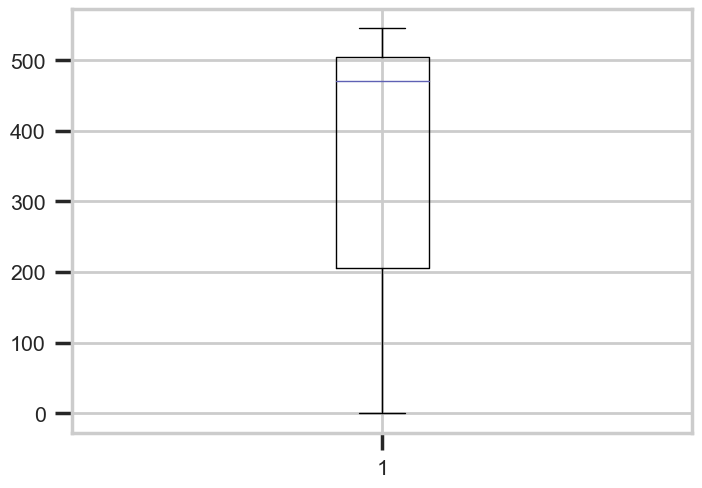

In [44]:
plt.boxplot(rfm.recency)
Q1 = rfm.recency.quantile(0.25)
Q3 = rfm.recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

#### Outlier treatment for frequency

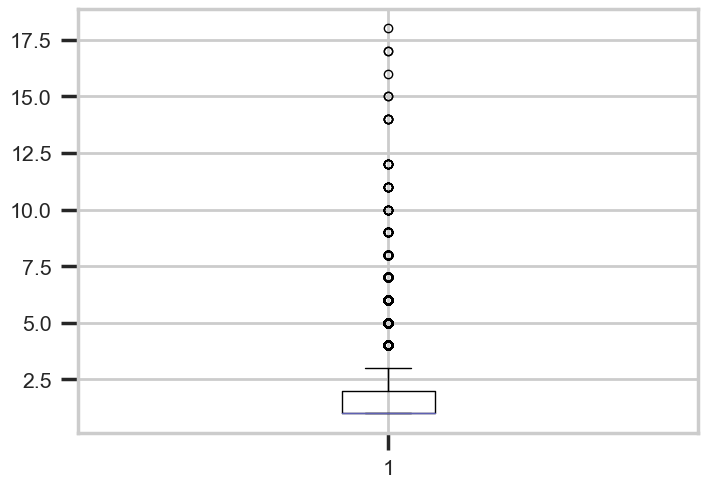

In [45]:
plt.boxplot(rfm.frequency)
Q1 = rfm.frequency.quantile(0.25)
Q3 = rfm.frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

##### Outlier treatment for monetary

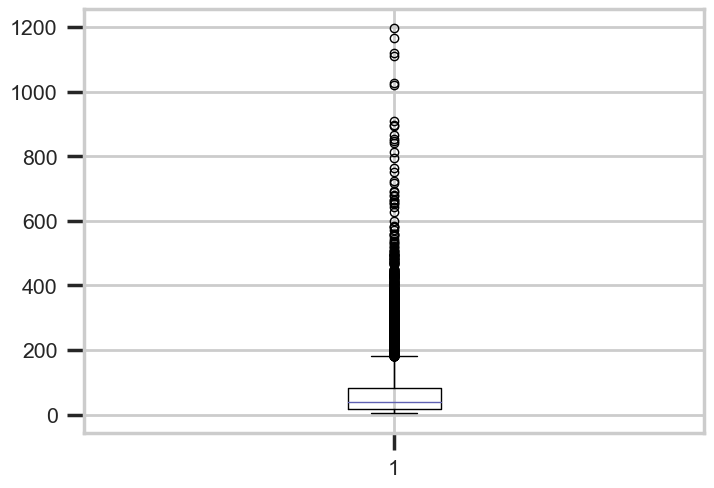

In [46]:
plt.boxplot(rfm.monetary)
Q1 = rfm.monetary.quantile(0.25)
Q3 = rfm.monetary.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary >= (Q1 - 1.5*IQR)) & (rfm.monetary <= (Q3 + 1.5*IQR))]

## K Means

### Transforming the data

In [47]:
rfm1=rfm[['recency','frequency','monetary']]
scaler = StandardScaler()
x_scaled = scaler.fit(rfm1)
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[ 0.88358987, -0.57588243, -0.92442882],
       [ 0.81341666,  1.13163926,  0.95417421],
       [-1.31729707,  1.13163926,  1.23390922],
       ...,
       [ 0.17547842,  1.13163926,  1.74959463],
       [ 0.35410112, -0.57588243, -0.58461159],
       [ 0.34772174,  1.13163926,  1.07774411]])

#### Elbow method

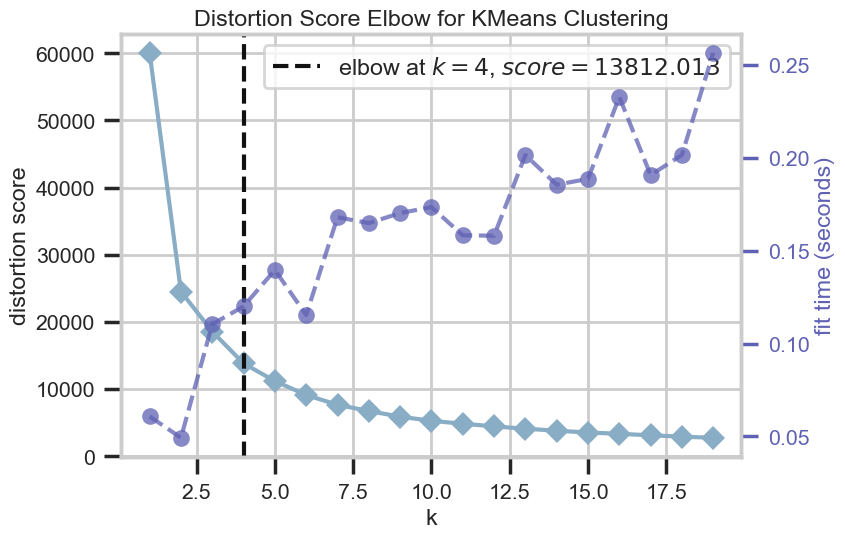

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(x_scaled)  
visualizer.show()   

According to the Elbow method, the number of clusters is **4**.

### Applying K-Means

[2 2 3 ... 0 2 2]
 Our cluster centers are as follows
[[ 0.55745376 -0.57588243 -0.54605114]
 [-1.59416992  2.09003812  2.05685778]
 [-1.73068704  0.40241998  0.29390322]
 [ 0.17443333  0.82730282  0.81253959]]


recency  frequency  monetary
cluster_pred                              
0               12831      12831     12831
1                2000       2000      2000
2                2556       2556      2556
3                2636       2636      2636

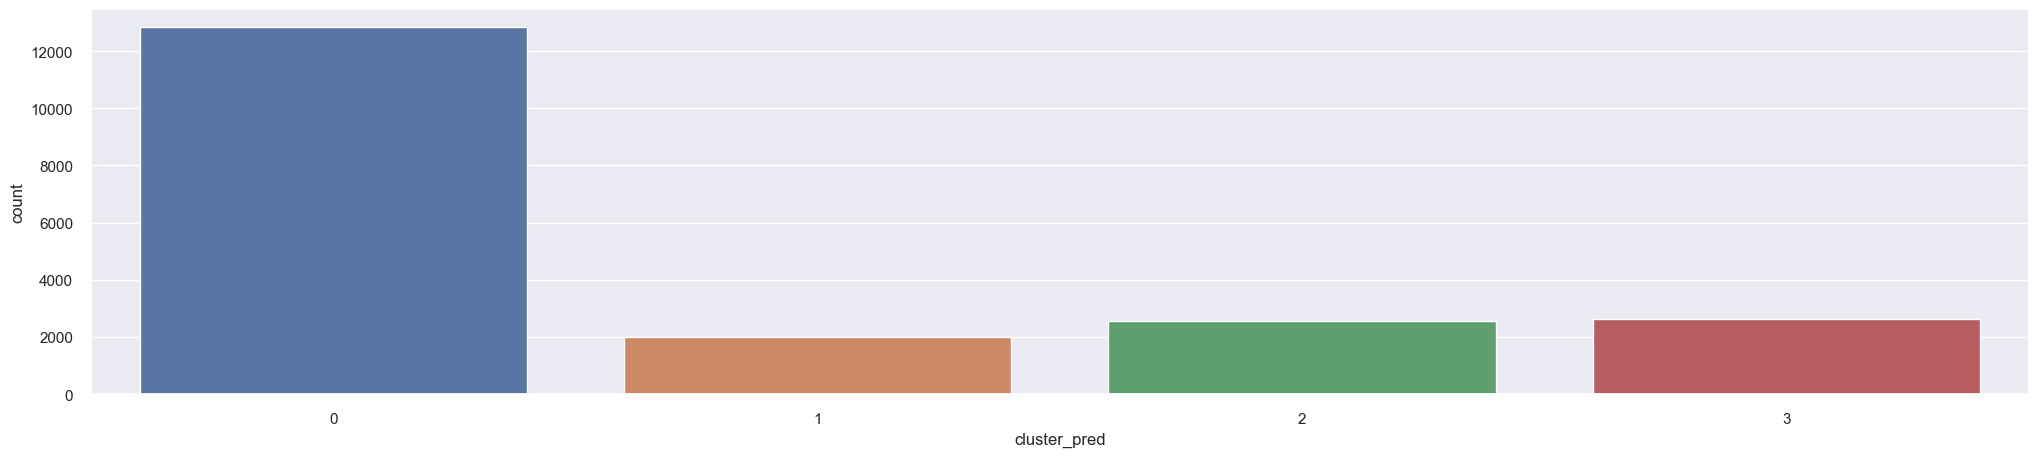

In [49]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

### Validation

We will use Silhoutte score to validate our clusters.

Silhouette Score: 0.583


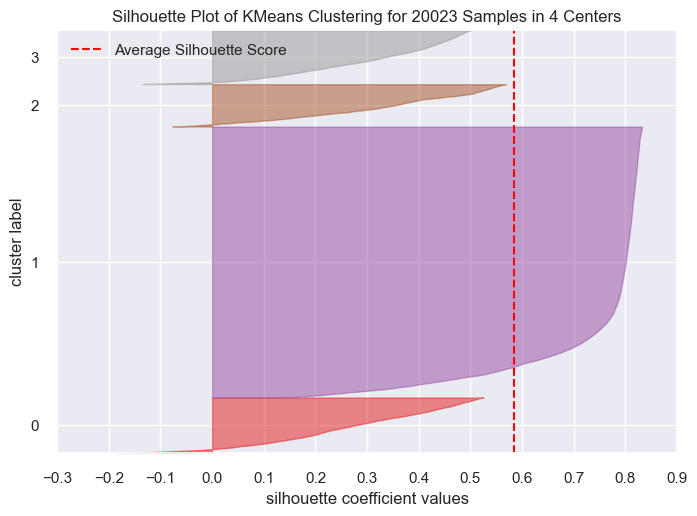

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 20023 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   

### Cluster Profiling

In [51]:
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['level']=rfm['level']

rfm1.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

C:\Users\DELL\AppData\Local\Temp\ipykernel_20876\3470046792.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\AppData\Local\Temp\ipykernel_20876\3470046792.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



recency           frequency            monetary                 \
               mean  min  max      mean min max        mean    min     max   
cluster                                                                      
0        493.845998  252  545  1.000000   1   1   27.321345   3.99   90.18   
1        156.844500    0  517  2.562000   1   3  134.303005  50.34  180.51   
2        135.106025    0  311  1.573552   1   2   61.897175   9.48  169.45   
3        433.857739  233  545  1.820561   1   3   83.171847  17.54  180.29   

                
         count  
cluster         
0        12831  
1         2000  
2         2556  
3         2636

Theo tóm tắt trên ta có thể thấy:

- **Cụm 1** là nhóm khách hàng có giá trị nhất với **tần suất trung bình cao nhất** (mua hàng thường xuyên nhất), **số ngày mua hàng gần đây trung bình gần như ít nhất** (mới mua hàng từ công ty) và **số tiền trung bình cao nhất ** (số lượng mua cao).
    
    
- Mặt khác, **Cụm 0** là nhóm khách hàng có **tần suất ít nhất** và **giá trị tiền tệ thấp nhất** và **số ngày mua hàng gần đây trung bình đây lớn nhất**.

In [52]:
rfm1.head()

recency  frequency  monetary  cluster     level
CustomerID                                                 
1               545          1     11.77        0  Inactive
2               534          2     89.00        3      Good
4               200          2    100.50        2    Active
6               545          1     20.99        0   Average
9                22          1     95.85        2      Good

### Nature of the cluster

Kiểm tra các cụm được dự đoán là **đồng nhất** hay **không đồng nhất** về bản chất.

In [53]:
rfm1.groupby(['cluster','level']).size()

cluster  level   
0        Active        47
         Average     8169
         Good        3185
         Inactive    1430
1        Active      2000
2        Active      1752
         Average       43
         Good         761
3        Active      1513
         Average      144
         Good         979
dtype: int64

### Observations

**Cụm 0** về bản chất là **không đồng nhất**. Nó bao gồm **cả 4 loại khách hàng**.

**Cụm 1** về bản chất là **đồng nhất**. Nó bao gồm **khách hàng Active**.

**Cụm 2** về bản chất là **không đồng nhất** vì có toàn bộ **khách hàng Active, Average và Good**.

**Cụm 3** về bản chất là **không đồng nhất**. Nó bao gồm **khách hàng Active, Average và Good**.

### Visualizing the clusters

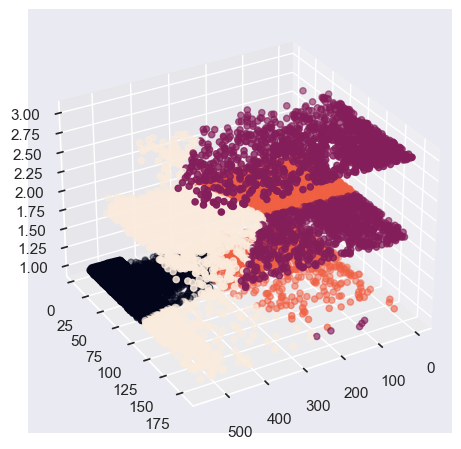

In [54]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['recency']
yline=clusters_scaled['frequency']
zline=clusters_scaled['monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

#### Calculate mean values for each segment

In [55]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg_kmeans = rfm1.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(0)

rfm_agg_kmeans.columns = rfm_agg_kmeans.columns.droplevel()
rfm_agg_kmeans.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg_kmeans['Percent'] = round((rfm_agg_kmeans['Count']/rfm_agg_kmeans.Count.sum())*100, 2)

# Reset the index
rfm_agg_kmeans = rfm_agg_kmeans.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg_kmeans['cluster'] = 'Cluster '+ rfm_agg_kmeans['cluster'].astype('str')

In [56]:
rfm_agg_kmeans

cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        494.0            1.0          27.0  12831    64.08
1  Cluster 1        157.0            3.0         134.0   2000     9.99
2  Cluster 2        135.0            2.0          62.0   2556    12.77
3  Cluster 3        434.0            2.0          83.0   2636    13.16

#### TreeMap

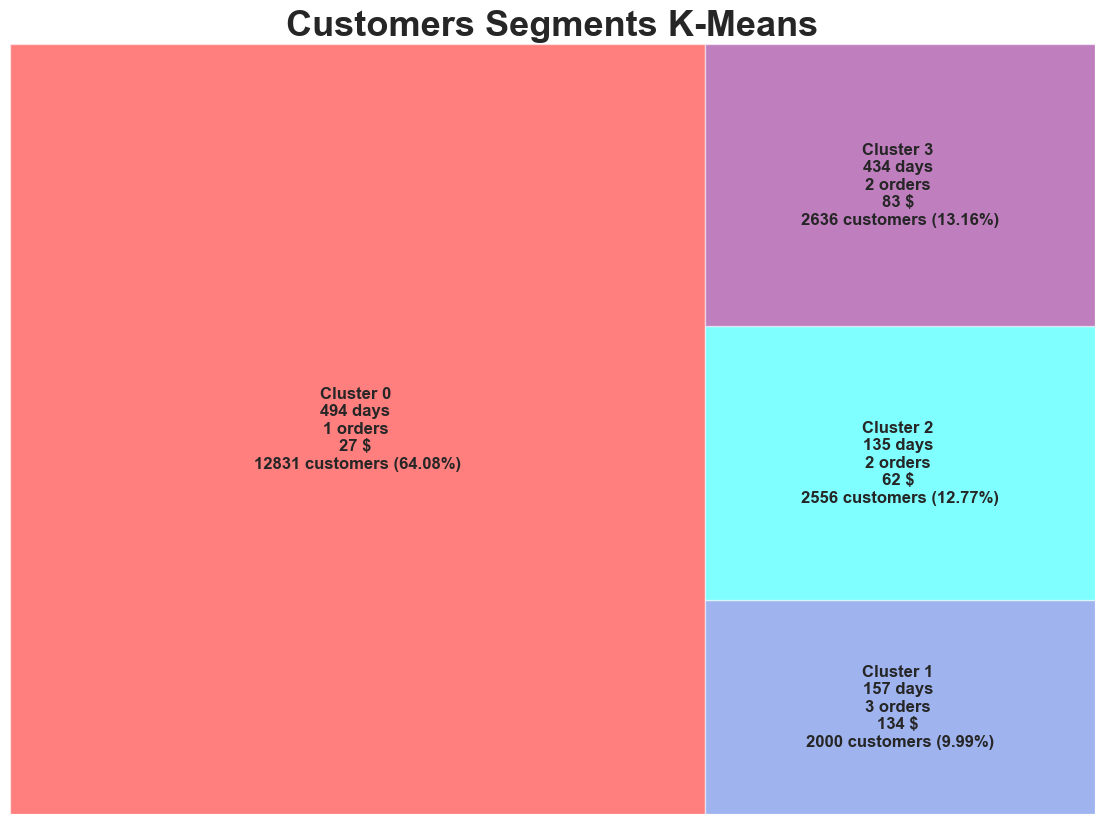

In [57]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'Cluster0':'red','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'purple'}

squarify.plot(sizes=rfm_agg_kmeans['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_kmeans.iloc[i])
                      for i in range(0, len(rfm_agg_kmeans))], alpha=0.5 )


plt.title("Customers Segments K-Means",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

#### Scatter Plot (RFM)

In [58]:
import plotly.express as px

fig = px.scatter(rfm_agg_kmeans, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

#### 3d Scatter Plot (RFM)

In [59]:
import plotly.express as px

fig = px.scatter_3d(rfm_agg_kmeans, x='RecencyMean', y='FrequencyMean', z='MonetaryMean', hover_name="cluster",
                    color = 'cluster', opacity=0.3)
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
fig.show()

### Comparing RFM analysis and Clusters

**Chuyển đổi** và lưu trữ các giá trị RFM để vẽ snake plot.

In [60]:
rfm_scaled=pd.DataFrame()
rfm_scaled=rfm1.copy()
scaler=StandardScaler()
rfm_scaled[['recency', 'frequency','monetary']] = scaler.fit_transform(rfm_scaled[['recency', 'frequency','monetary']])
rfm_scaled['cust_id']=rfm1.index

In [61]:
rfm_scaled.head()

recency  frequency  monetary  cluster     level  cust_id
CustomerID                                                           
1           0.883590  -0.575882 -0.924429        0  Inactive        1
2           0.813417   1.131639  0.954174        3      Good        2
4          -1.317297   1.131639  1.233909        2    Active        4
6           0.883590  -0.575882 -0.700154        0   Average        6
9          -2.452827  -0.575882  1.120799        2      Good        9

#### Melting the dataframe

In [62]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['cust_id', 'level', 'cluster'], var_name = 'metrics', value_name = 'value')
rfm_melted.head()

cust_id     level  cluster  metrics     value
0        1  Inactive        0  recency  0.883590
1        2      Good        3  recency  0.813417
2        4    Active        2  recency -1.317297
3        6   Average        0  recency  0.883590
4        9      Good        2  recency -2.452827

### Snake plot 

[(-3.0, 3.0)]

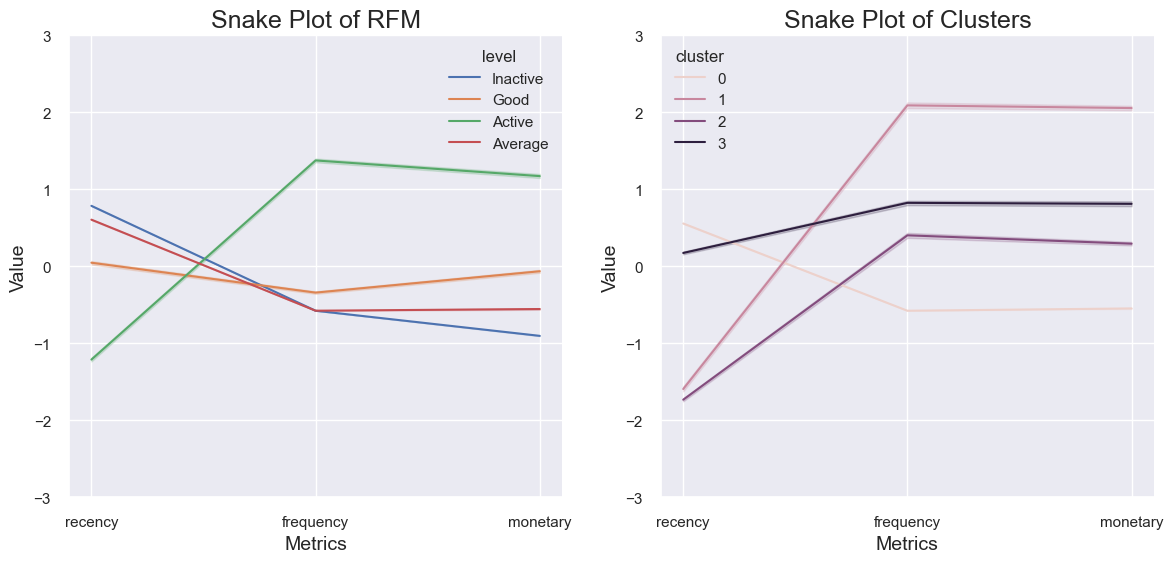

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted, ax = ax[1])
sns.despine(left = False, bottom = False)
ax[1].set_title('Snake Plot of Clusters', fontsize = 18)
ax[1].set_xlabel('Metrics', fontsize = 14)
ax[1].set_ylabel('Value', fontsize = 14)
ax[1].set(ylim=(-3, 3))

sns.lineplot(x = 'metrics', y = 'value', hue = 'level', data = rfm_melted, ax = ax[0])
sns.despine(left = False, bottom = False)
ax[0].set_title('Snake Plot of RFM', fontsize = 18)
ax[0].set_xlabel('Metrics', fontsize = 14)
ax[0].set_ylabel('Value', fontsize = 14)
ax[0].set(ylim=(-3, 3))

### Nhận xét:
    Biểu đồ snake plot cho thấy:
        * Có 1 nhóm giống nhau và 3 nhóm khác nhau khi sử dụng RFM quantiles và RFM K-means Clustering (Nhóm Average giống với Cụm 0).
        * Theo biểu đồ thì các cụm do K-means phân ra có vẻ rõ ràng hơn so với khi dùng RFM quantiles.

## Hierachical Clustering

In [64]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [65]:
rfm2=rfm[['recency','frequency','monetary']]
scaler = StandardScaler()
x_scaled_2 = scaler.fit(rfm2)
x_scaled_2 = scaler.fit_transform(rfm2)
x_scaled_2

array([[ 0.88358987, -0.57588243, -0.92442882],
       [ 0.81341666,  1.13163926,  0.95417421],
       [-1.31729707,  1.13163926,  1.23390922],
       ...,
       [ 0.17547842,  1.13163926,  1.74959463],
       [ 0.35410112, -0.57588243, -0.58461159],
       [ 0.34772174,  1.13163926,  1.07774411]])

Duration: 0:00:18.669524


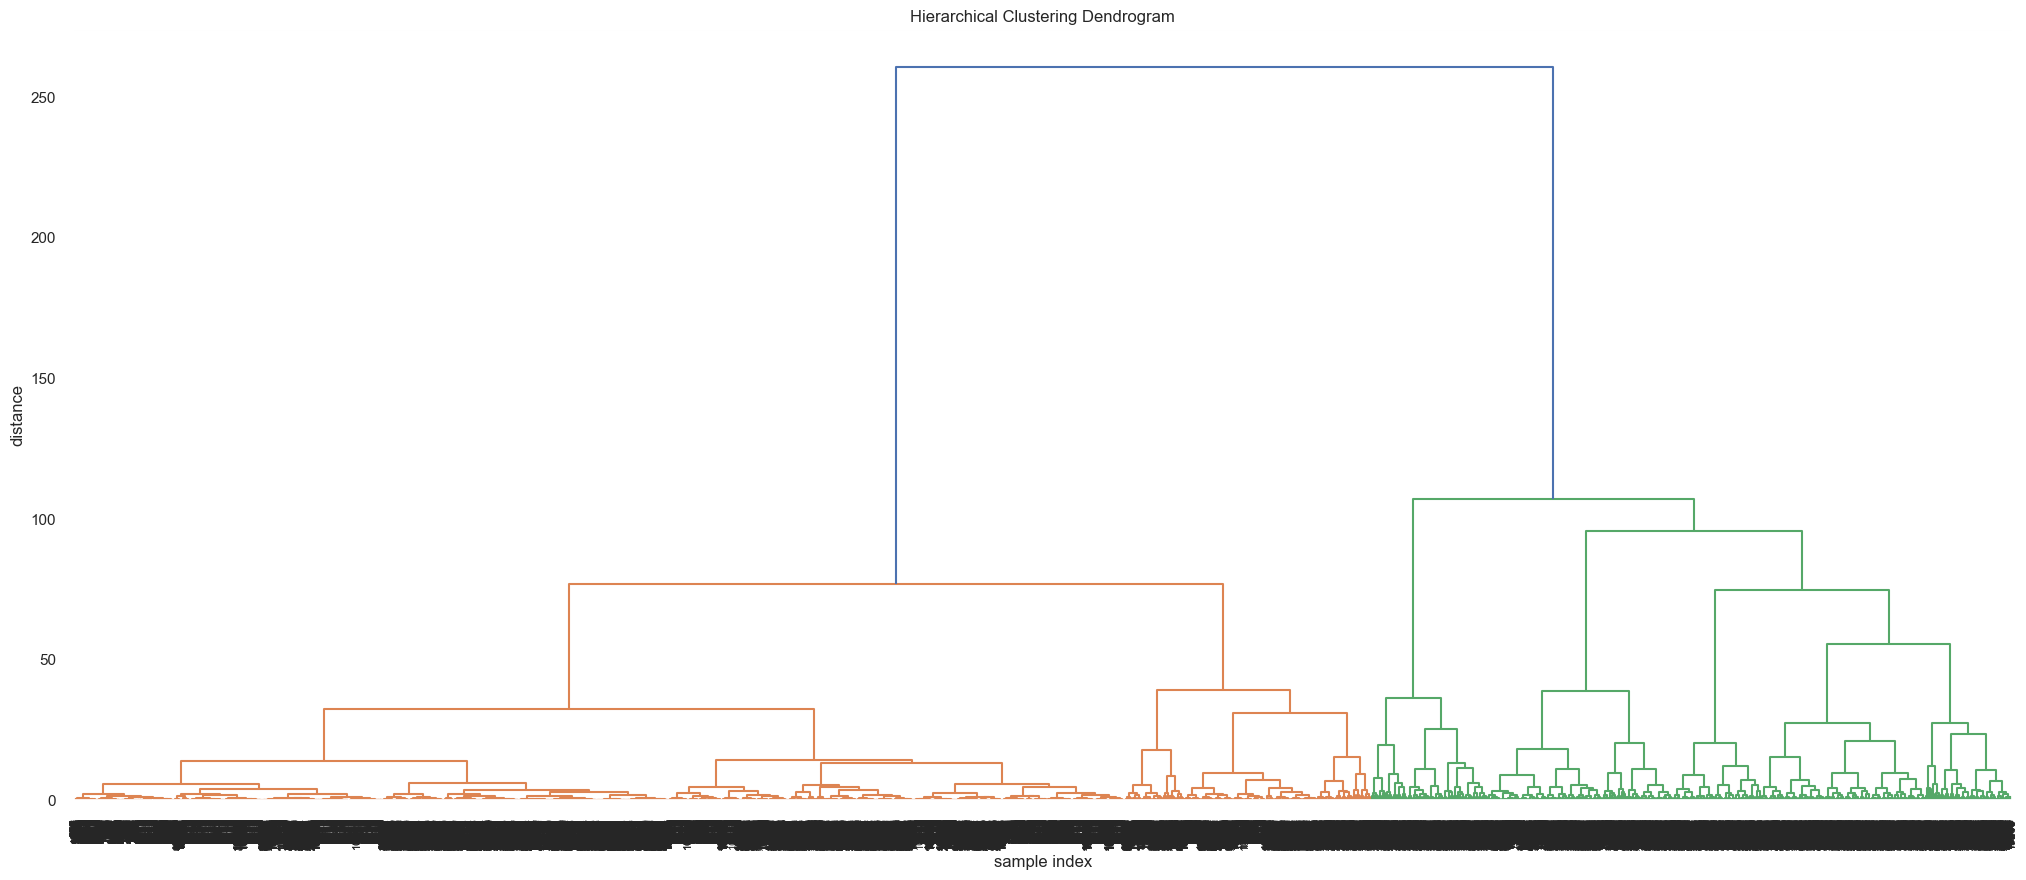

In [66]:
# Draw a dendrogram
start_time = datetime.now()
Z = linkage(x_scaled_2, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
plt.show()

### Use AgglomerativeClustering with n_clusters = 4

### Applying Hierachical

[1 1 2 ... 0 1 0]
 Our cluster centers are as follows


recency  frequency  monetary
cluster_pred                              
0               13410      13410     13410
1                3502       3502      3502
2                1196       1196      1196
3                1915       1915      1915

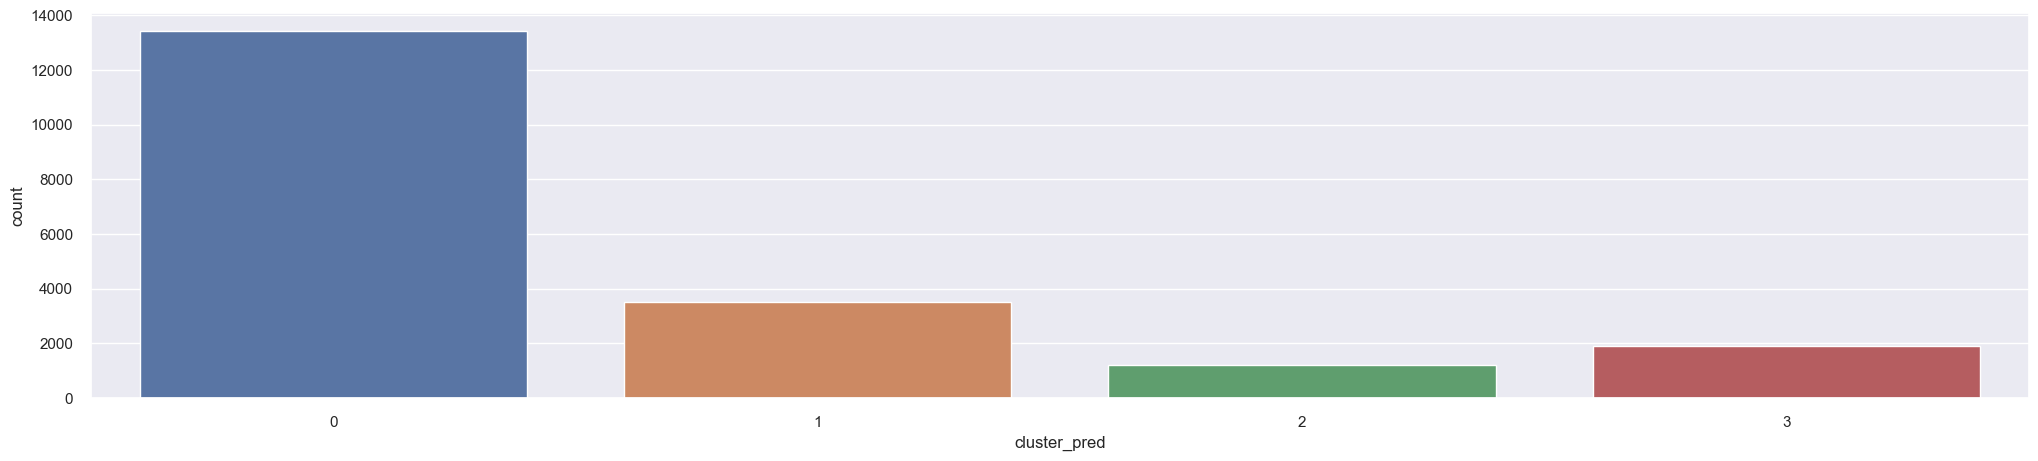

In [67]:
hc_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hc_cluster.fit(x_scaled_2)
identified_clusters = hc_cluster.fit_predict(rfm2)
clusters_scaled_2 = rfm2.copy()
clusters_scaled_2['cluster_pred']=hc_cluster.fit_predict(x_scaled_2)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
# print(hc_cluster.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled_2)
clusters_scaled_2.groupby(['cluster_pred']).count()

### Validation

We will use Silhoutte score to validate our clusters.

In [68]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled_2, hc_cluster.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

Silhouette Score: 0.560


### Cluster Profiling

We are going to analyse and understand our clusters.

In [69]:
rfm2['cluster']= clusters_scaled_2['cluster_pred']
rfm2['level']=rfm['level']

rfm2.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

C:\Users\DELL\AppData\Local\Temp\ipykernel_20876\1008094839.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\AppData\Local\Temp\ipykernel_20876\1008094839.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



recency           frequency            monetary                 \
               mean  min  max      mean min max        mean    min     max   
cluster                                                                      
0        492.027442  174  545  1.000000   1   1   31.027831   3.99  180.29   
1        141.003998    0  438  1.698458   1   2   81.202053   9.48  180.31   
2        186.732441    0  528  3.000000   3   3  129.581112  50.34  180.51   
3        430.282507  267  544  2.000000   2   2   73.725614  17.54  180.15   

                
         count  
cluster         
0        13410  
1         3502  
2         1196  
3         1915

 From the above summary we get to know that,
    
- **Cluster 0** is the most valuable group of customers with **highest mean frequency** (purchase most often), **least mean recency** (has recently purchased from the company) and the **highest mean monetary** (high purchasing amount).
    
    
- On the other hand, **Cluster 2** is the group of customers with **least frequency** and **monetary** and **recency values**.


In [70]:
rfm2.head()

recency  frequency  monetary  cluster     level
CustomerID                                                 
1               545          1     11.77        0  Inactive
2               534          2     89.00        3      Good
4               200          2    100.50        1    Active
6               545          1     20.99        0   Average
9                22          1     95.85        1      Good

### Nature of the cluster

We need to check whether the predicted clusters are **homogeneous** or **heterogeneous** in nature.

In [71]:
rfm2.groupby(['cluster','level']).size()

cluster  level   
0        Active       131
         Average     8295
         Good        3554
         Inactive    1430
1        Active      2736
         Average       59
         Good         707
2        Active      1193
         Good           3
3        Active      1252
         Average        2
         Good         661
dtype: int64

### Observations

**Cụm 0** về bản chất là **không đồng nhất**. Nó bao gồm **cả 4 loại khách hàng**.

**Cụm 1** về bản chất là **không đồng nhất**. Nó bao gồm **khách hàng Active, Average và Good**.

**Cụm 2** về bản chất là **đồng nhất** vì có gần như toàn bộ **khách hàng Active**.

**Cụm 3** về bản chất là **không đồng nhất** vì có gần như toàn bộ **khách hàng Active và Good**.

### Visualizing the clusters

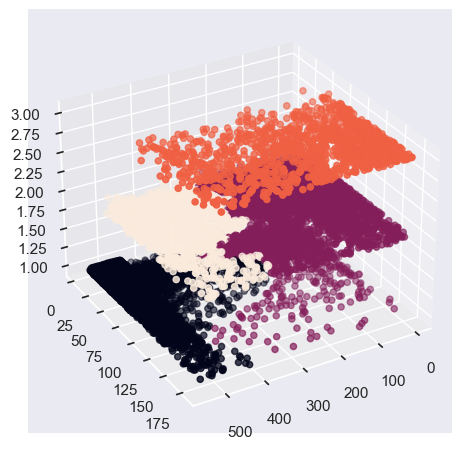

In [72]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled_2['recency']
yline=clusters_scaled_2['frequency']
zline=clusters_scaled_2['monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled_2['cluster_pred'])
ax.view_init(30, 60)

#### Calculate mean values for each segment

In [73]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg_hc = rfm2.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(0)

rfm_agg_hc.columns = rfm_agg_hc.columns.droplevel()
rfm_agg_hc.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg_hc['Percent'] = round((rfm_agg_hc['Count']/rfm_agg_hc.Count.sum())*100, 2)

# Reset the index
rfm_agg_hc = rfm_agg_hc.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg_hc['cluster'] = 'Cluster '+ rfm_agg_hc['cluster'].astype('str')

In [74]:
rfm_agg_hc

cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0        492.0            1.0          31.0  13410    66.97
1  Cluster 1        141.0            2.0          81.0   3502    17.49
2  Cluster 2        187.0            3.0         130.0   1196     5.97
3  Cluster 3        430.0            2.0          74.0   1915     9.56

#### TreeMap

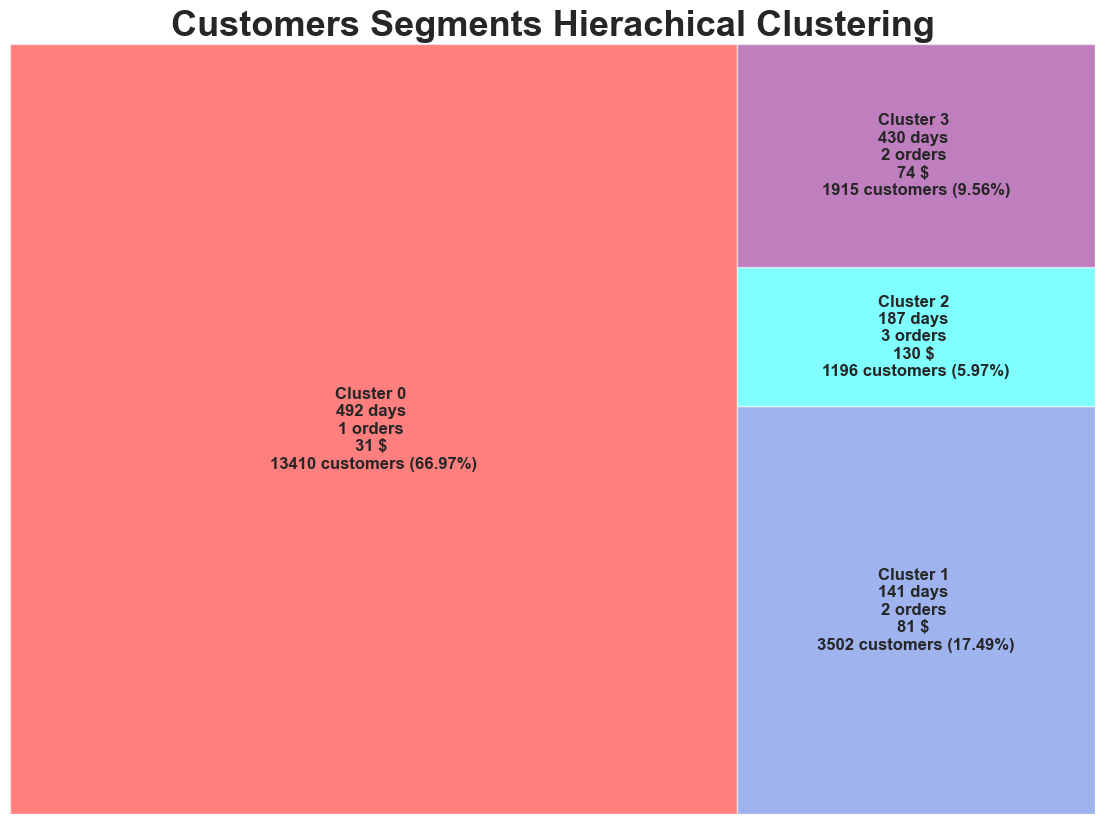

In [75]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'Cluster0':'red','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'purple'}

squarify.plot(sizes=rfm_agg_hc['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_hc.iloc[i])
                      for i in range(0, len(rfm_agg_hc))], alpha=0.5 )


plt.title("Customers Segments Hierachical Clustering",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

#### Scatter Plot (RFM)

In [76]:
import plotly.express as px

fig = px.scatter(rfm_agg_hc, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="cluster",
           hover_name="cluster", size_max=100)
fig.show()

#### 3d Scatter Plot (RFM)

In [77]:
import plotly.express as px

fig = px.scatter_3d(rfm_agg_hc, x='RecencyMean', y='FrequencyMean', z='MonetaryMean', hover_name="cluster",
                    color = 'cluster', opacity=0.3)
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
fig.show()

### Comparing RFM analysis and Hierachical Clustering

**Transforming** and storing the RFM values for plotting a snake plot.

In [78]:
rfm_scaled_2=pd.DataFrame()
rfm_scaled_2=rfm2.copy()
scaler=StandardScaler()
rfm_scaled_2[['recency', 'frequency','monetary']] = scaler.fit_transform(rfm_scaled_2[['recency', 'frequency','monetary']])
rfm_scaled_2['cust_id']=rfm2.index

In [79]:
rfm_scaled_2.head()

recency  frequency  monetary  cluster     level  cust_id
CustomerID                                                           
1           0.883590  -0.575882 -0.924429        0  Inactive        1
2           0.813417   1.131639  0.954174        3      Good        2
4          -1.317297   1.131639  1.233909        1    Active        4
6           0.883590  -0.575882 -0.700154        0   Average        6
9          -2.452827  -0.575882  1.120799        1      Good        9

#### Melting the dataframe

In [80]:
rfm_melted_2 = pd.melt(frame= rfm_scaled_2, id_vars= ['cust_id', 'level', 'cluster'], var_name = 'metrics', value_name = 'value')
rfm_melted_2.head()

cust_id     level  cluster  metrics     value
0        1  Inactive        0  recency  0.883590
1        2      Good        3  recency  0.813417
2        4    Active        1  recency -1.317297
3        6   Average        0  recency  0.883590
4        9      Good        1  recency -2.452827

### Snake plot

[(-3.0, 3.0)]

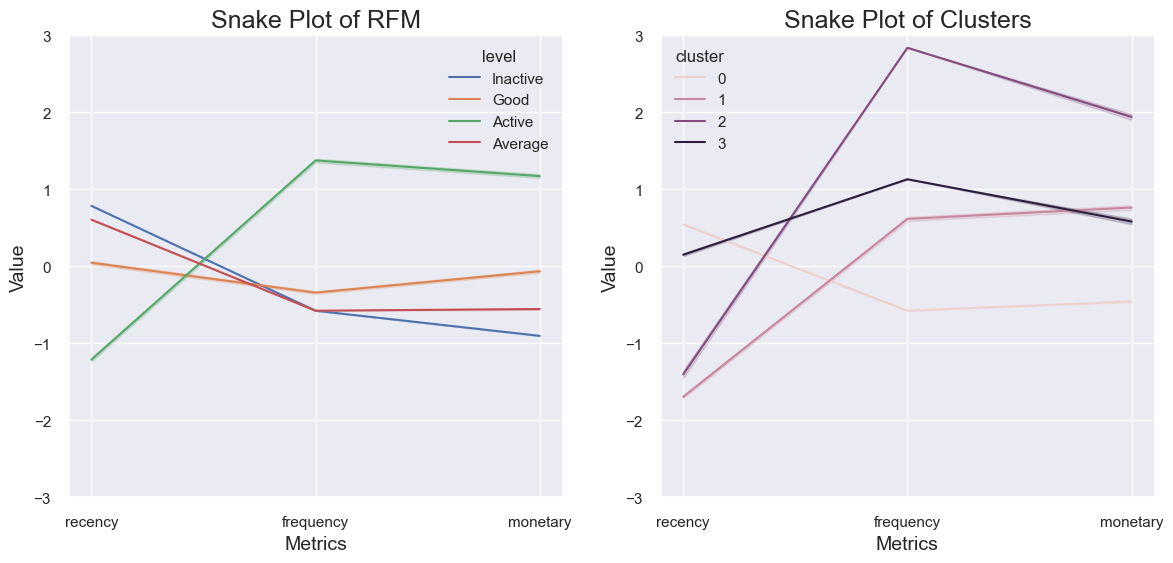

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted_2, ax = ax[1])
sns.despine(left = False, bottom = False)
ax[1].set_title('Snake Plot of Clusters', fontsize = 18)
ax[1].set_xlabel('Metrics', fontsize = 14)
ax[1].set_ylabel('Value', fontsize = 14)
ax[1].set(ylim=(-3, 3))

sns.lineplot(x = 'metrics', y = 'value', hue = 'level', data = rfm_melted_2, ax = ax[0])
sns.despine(left = False, bottom = False)
ax[0].set_title('Snake Plot of RFM', fontsize = 18)
ax[0].set_xlabel('Metrics', fontsize = 14)
ax[0].set_ylabel('Value', fontsize = 14)
ax[0].set(ylim=(-3, 3))

### Nhận xét:
    Biểu đồ snake plot cho thấy:
        * Có 1 nhóm giống nhau và 3 nhóm khác nhau khi sử dụng RFM quantiles và RFM Hierachical Clustering (Nhóm Average gần giống với Cụm 0).
        * Theo biểu đồ thì các cụm do Hierachical phân ra có vẻ rõ ràng hơn so với khi dùng RFM quantiles.

## Conclusion

### Sau khi sử dụng RFM quantiles, RFM + K-means Clustering và RFM + Hierachical Clustering để phân nhóm khách hàng thì thuật toán RFM + K-means Clustering cho ra các cụm rõ ràng nhất có thể xếp vào 4 loại khách hàng khác nhau để đưa ra các chiến lược marketing phù hợp 

In [86]:
customers_segments = ['At risk to lost', 'Royal customers', 'Recent customers', 'Cooling down']
customers_segments

['At risk to lost', 'Royal customers', 'Recent customers', 'Cooling down']

In [87]:
rfm_agg_kmeans = rfm_agg_kmeans.rename(columns = {'cluster' : 'customers_segments'})
rfm_agg_kmeans.customers_segments = customers_segments

In [88]:
rfm_agg_kmeans

customers_segments  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0    At risk to lost        494.0            1.0          27.0  12831    64.08
1    Royal customers        157.0            3.0         134.0   2000     9.99
2   Recent customers        135.0            2.0          62.0   2556    12.77
3       Cooling down        434.0            2.0          83.0   2636    13.16

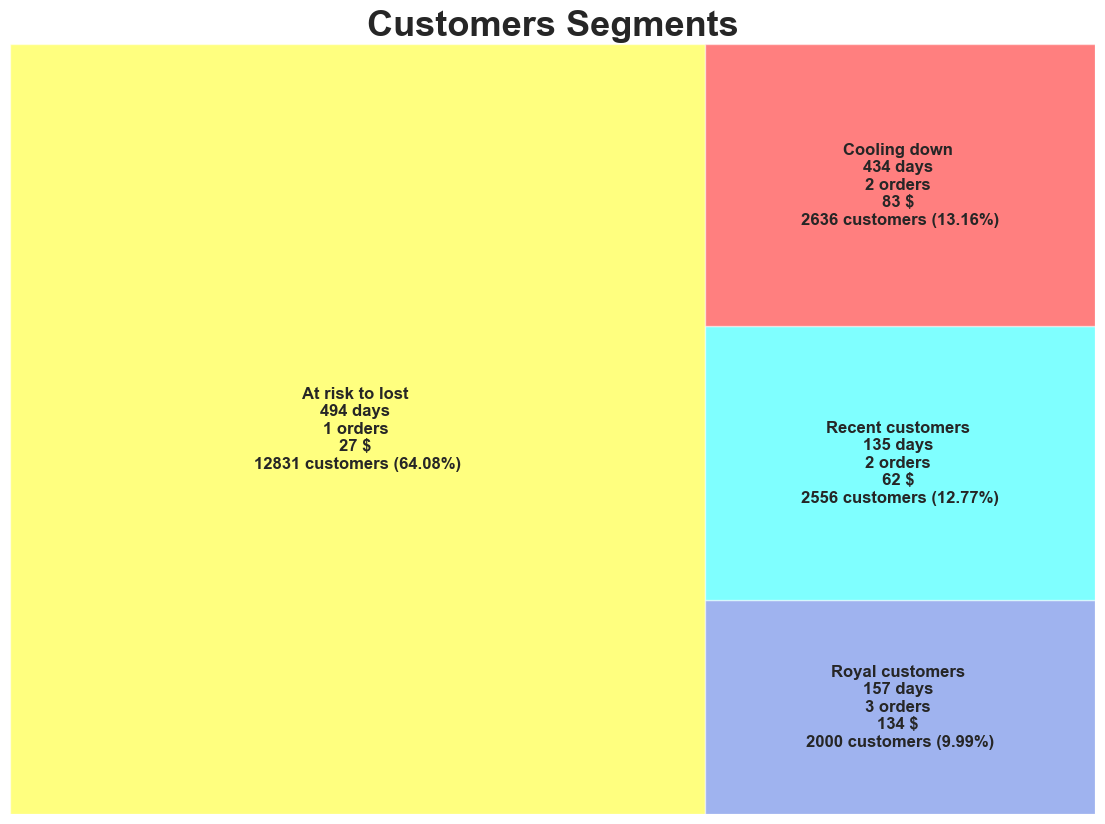

In [89]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg_kmeans['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_kmeans.iloc[i])
                      for i in range(0, len(rfm_agg_kmeans))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Unsupervised Segments.png')
plt.show()